In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import subprocess
from glob import glob
from pkg import *

In [2]:
# dataset_num = input("Enter dataset number: ")
# dataset = dataset_num.zfill(2) # string (ex '01')
dataset = '01'

myPaths = pm.PathManager(dataset=dataset)
myProcessor = p.Processor(paths=myPaths, dataset=dataset)
clen, photon_energy = myProcessor.get_parameters()
print(f"clen: {clen}, photon_energy: {photon_energy}")

f.get_counts(paths=myPaths)

clen: 1.5, photon_energy: 6000
Paths refreshed for dataset 01.
Directory: peaks/01
	Total files: 58
	Normal images: 39
	Empty images: 19
Directory: labels/01
	Total files: 97
	Normal images: 78
	Empty images: 19
Directory: peaks_water_overlay/01
	Total files: 97
	Normal images: 78
	Empty images: 19


In [3]:
# f.get_counts(paths=myPaths)

# %run process_directory.py ../../images  --percent_empty 0.5 

f.get_counts(paths=myPaths)


Paths refreshed for dataset 01.
Directory: peaks/01
	Total files: 58
	Normal images: 39
	Empty images: 19
Directory: labels/01
	Total files: 97
	Normal images: 78
	Empty images: 19
Directory: peaks_water_overlay/01
	Total files: 97
	Normal images: 78
	Empty images: 19


In [4]:
myDataManager = dm.DatasetManager(paths=myPaths, dataset=dataset, parameters=[clen,photon_energy], transform=None)

# peak, label, overlay are valid types
clen, photon_energy = myProcessor.get_parameters()

f.check_attributes(paths=myPaths, dataset=dataset, type='peak', clen=clen, photon_energy=photon_energy) 
f.check_attributes(paths=myPaths, dataset=dataset, type='overlay', clen=clen, photon_energy=photon_energy)
f.check_attributes(paths=myPaths, dataset=dataset, type='label', clen=clen, photon_energy=photon_energy)

train_loader, test_loader = f.prepare(data_manager=myDataManager, batch_size=10)

Paths refreshed for dataset 01.
Directory: peaks/01
	Total files: 58
	Normal images: 39
	Empty images: 19
Directory: labels/01
	Total files: 97
	Normal images: 78
	Empty images: 19
Directory: peaks_water_overlay/01
	Total files: 97
	Normal images: 78
	Empty images: 19
Paths refreshed for dataset 01.
Actual percentage of empty images: 26.76056338028169% across peaks, water_overlays, and labels directories.

All files in dataset 01 of type 'peak' have matching attributes.
All files in dataset 01 of type 'label' have matching attributes.
All files in dataset 01 of type 'overlay' have matching attributes.
All files in dataset 01 of type 'background' have matching attributes.
Dataset 01 authenticated.

Final dataset sizes - Peaks: 58, Labels: 58, Overlays: 97
All files in dataset 01 of type 'peak' have matching attributes.
All files in dataset 01 of type 'overlay' have matching attributes.
All files in dataset 01 of type 'label' have matching attributes.

Data prepared.
Train size: 46
Test 

In [5]:
f.check_attributes(paths=myPaths, dataset=dataset, type='peak', clen=clen, photon_energy=photon_energy)
test_path = myPaths.get_peak_image_paths(dataset)[0]
test = f.retrieve_attributes(test_path) 
print(test)

All files in dataset 01 of type 'peak' have matching attributes.
{'clen': 1.5, 'params': array([5.e-01, 9.e+03]), 'peak': False, 'photon_energy': 6000}


In [6]:
dir(m)

['BasicCNN1',
 'BasicCNN2',
 'BasicCNN3',
 'DenseNet121_Weights',
 'DenseNetBraggPeakClassifier',
 'F',
 'Photon_Scattering_CNN1',
 'ResNet50BraggPeakClassifier',
 'ResNet50_Weights',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'models',
 'nn',
 'np',
 'optim',
 'os',
 'torch']

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
print(device)

model1 = m.Photon_Scattering_CNN1().to(device)
# model1 = m.BasicCNN3().to(device)
# criterion = nn.BCEWithLogitsLoss()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model1.parameters(), lr=0.001)

feature = 'photon_energy'
# feature = 'peak'

cfg = {
    'num_epochs': 2,
    'num_classes': 3,
    'batch_size': train_loader.batch_size,
    'test_size': len(train_loader.dataset),
    'test_size': len(test_loader.dataset),
    'criterion': criterion,
    'optimizer': optimizer,
    'device': device,
    'model': model1,
    }

labels = {
    'peaks': ["True", "False"],
    "photon_energy": [6000, 7000, 8000],
    "clen": ["1.5", "2.5", "3.5"]
}

# # arguments: self, model, loader: list, criterion, optimizer, device, cfg: dict
t = train_eval.TrainTestModels(model=model1, loader=[train_loader, test_loader], criterion=criterion, optimizer=optimizer, device=device, cfg=cfg, feature=feature, labels=labels['photon_energy'])

cuda


Model testing and validating: Photon_Scattering_CNN1
Looking for the feature: photon_energy
-- epoch 0
Train loss: 0.8804052591323852
Train accuracy: 1.0
Test loss: 0.1419653296470642
Test accuracy: 1.0
-- epoch 1
Train loss: 0.2571529299020767
Train accuracy: 1.0
Test loss: 2.171635642298497e-05
Test accuracy: 1.0


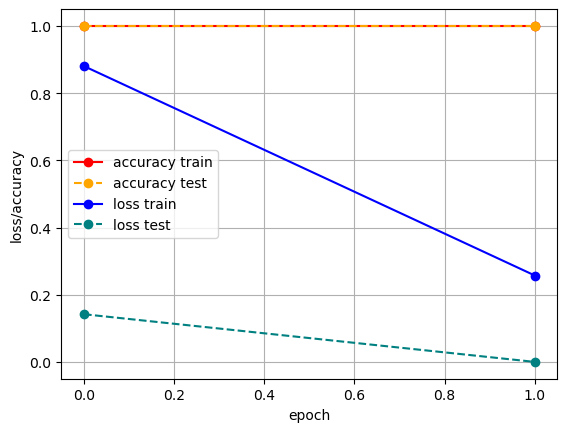

In [8]:
t.epoch_loop()
t.plot_loss_accuracy()

labels: ['6000', '7000', '8000']
truth: [6000 6000 6000 6000 6000 6000 6000 6000 6000 6000 6000 6000]
prediction: [6000 6000 6000 6000 6000 6000 6000 6000 6000 6000 6000 6000]


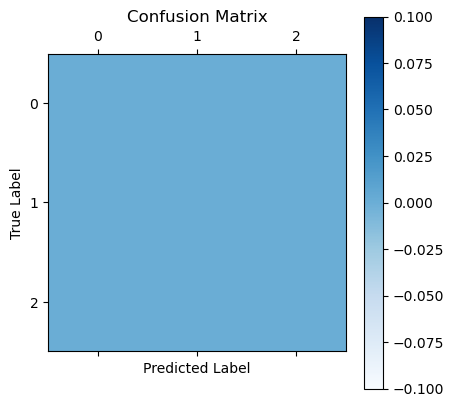

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [9]:
t.plot_confusion_matrix()
t.get_confusion_matrix()

In [10]:
test_peaks = myPaths.get_peak_image_paths(dataset=dataset)[0]
test_water = myPaths.get_peaks_water_overlay_image_paths(dataset=dataset)[0]
test_overlay = myPaths.get_peaks_water_overlay_image_paths(dataset=dataset)[0]
param1, param2 = (0.5, 9000), (0.5, 9000, True)
f.assign_attributes(file_path=test_peaks, params=param1)

Attributes ['params'] assigned to c:\Users\eseveret\Desktop\cxls_hitfinder\images\peaks\01\empty_peak_01_00001.h5


In [11]:
# t.save_model('../models/cnn3_test.pt')

In [12]:
# test_model = m.BasicCNN3()
# test_model.load_state_dict(torch.load('../models/cnn3_test.pt'))
# test_model.eval()


In [13]:
# for data, label, attribute in train_loader:
#     peak, _ = data
#     peak_image_attribute = attribute['peak']
#     output = test_model(peak)
#     print(peak_image_attribute)
#     print(torch.sigmoid(output).reshape(1,-1) > 0.5)
#     print('-------------------')